In [1]:
import pandas as pd
import requests
from selenium import webdriver
from selenium.webdriver.support.ui import Select
import numpy as np
import re
# plot feature importance manually
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot
from xgboost import plot_importance
from xgboost import plot_tree
import graphviz
from xgboost import DMatrix
import time
import pylab as pl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import sys

In [2]:
browser =  webdriver.Chrome(executable_path = '/opt/homebrew/bin/chromedriver') # You'll need to download drivers from link above
#browser.implicitly_wait(10) # probably unnecessary, just makes sure all pages you visit fully load


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2767767744.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser =  webdriver.Chrome(executable_path = '/opt/homebrew/bin/chromedriver') # You'll need to download drivers from link above


In [3]:
def scrape_stats(url):
    browser.get(url)
    time.sleep(7.5)
    select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))
    select.select_by_visible_text('All')
    data = pd.read_html(browser.page_source)
    data[0] = data[0].replace('-', np.nan)
    data[0].dropna(axis = 1, how = 'all', inplace = True)
    data[0].dropna(axis = 0, how = 'any', inplace = True)
    if isinstance(data[0].columns, pd.MultiIndex):
        data[0].columns = data[0].columns.droplevel([1, 2, 3, 4])
        data[0].columns = data[0].columns.map(' '.join)
        data[0] = data[0].rename(columns=lambda x: re.sub('Unnamed: ._level_0','',x))
    data[0].columns = data[0].columns.str.replace(' ', '')
    data[0].columns = data[0].columns.str.replace(chr(160), '')
    data[0].columns = data[0].columns.str.upper()
    data[0].columns = data[0].columns.str.lstrip()
    return data

In [28]:
def get_salary(year):    
    url = "https://hoopshype.com/salaries/players/20{0}-20{1}/"
    url = url.format(str(year).zfill(2), str(year+1).zfill(2))
    if year == 21:
        url = "https://hoopshype.com/salaries/players/"
    browser.get(url)
    col = '20{0}/{1}'.format(str(year).zfill(2), str(year+1).zfill(2))
    sal_df = pd.read_html(browser.page_source)[0]
    sal_df = sal_df.reset_index()
    sal_df = sal_df.drop_duplicates(subset = "Player", keep = "first")
    sal_df = sal_df.dropna(subset=[col])
    sal_df['Player'] = sal_df['Player'].str.split('\\').str[0]
    #sal_df = sal_df[~((sal_df["Signed Using"].str.contains("Pick", na=False)) & (sal_df['20{0}/{1}'.format(str(year).zfill(2), str(year+1).zfill(2))] < 12632950.0))]
    sal_df = sal_df[['Player', col]]
    return sal_df

In [90]:
def get_year(year):
    return '20{0}/{1}'.format(str(year).zfill(2), str(year+1).zfill(2))

In [5]:
#data = scrape_stats("https://www.nba.com/stats/players/passing/?sort=AST_ADJ&dir=1")
#data[0]


In [6]:
toScrape = ["https://www.nba.com/stats/players/speed-distance/?Season=20{0}-{1}&SeasonType=Regular%20Season", 
 "https://www.nba.com/stats/players/shooting/?Season=20{0}-{1}&SeasonType=Regular%20Season", 
 "https://www.nba.com/stats/players/traditional/?Season=20{0}-{1}&SeasonType=Regular%20Season",
 "https://www.nba.com/stats/players/hustle/?Season=20{0}-{1}&SeasonType=Regular%20Season",
 "https://www.nba.com/stats/players/passing/?Season=20{0}-{1}&SeasonType=Regular%20Season"]

#toScrape = [i.format(str(year).zfill(2), str(year+1).zfill(2)) for i in toScrape]

In [38]:
info = ['PLAYER', 'MIN', 'GP']
features = ['OREB', 'DREB', 'REB', 'LESSTHAN5FT.FGM',  '10-14FT.FGM', '15-19FT.FGM', '20-24FT.FGM',
            'STL', 'BLK', 'ASTADJ', 'PASSESMADE', 'LOOSEBALLSRECOVERED', 'DEFLECTIONS', 'CONTESTED2PTSHOTS',
            'CONTESTED3PTSHOTS', '3PM', 'SCREENASSISTS']

other = ['AVGSPEED', 'AVGSPEEDOFF', 'AVGSPEEDDEF']

In [8]:
data = {}
data_norm = {}
sal = {}
full_data = {}
years = range(16, 21)

In [9]:

for year in years:
    browser =  webdriver.Chrome(executable_path = '/opt/homebrew/bin/chromedriver') # You'll need to download drivers from link above
    for i, url in enumerate([i.format(str(year).zfill(2), str(year+1).zfill(2)) for i in toScrape]): 
        print(url)
        stats = scrape_stats(url)
        stats[0]
        #print(stats[0])
        if i == 0:
            data[year] = stats[0]
        else:
            data[year] = pd.merge(data[year], stats[0], how="left", left_on=["PLAYER"], right_on=["PLAYER"])
    data[year].rename(columns={'MIN_x':'MIN'}, inplace=True)
    data[year].rename(columns={'GP_x':'GP'}, inplace=True)
    data[year].drop(list(data[year].filter(regex = '_[xy]')), axis = 1, inplace = True)
    data[year] = data[year].loc[:,~data[year].columns.duplicated()]
    
    data_norm[year] = data[year].copy()
    
    data_norm[year][features] = data_norm[year][features].apply(pd.to_numeric, errors='coerce')
    data_norm[year][features] = data_norm[year][features].div(data[year]['MIN'], axis=0) * 36
    data_norm[year][features] = data_norm[year][features].apply(lambda x: np.log(x + 1))
    data_norm[year] = data_norm[year].dropna()
    data_norm[year]['TOTALMIN'] = data_norm[year]['MIN'] * data[year]['GP']
    data_norm[year] = data_norm[year][data_norm[year]['TOTALMIN'] > 350]

    browser =  webdriver.Chrome(executable_path = '/opt/homebrew/bin/chromedriver') # You'll need to download drivers from link above
    sal[year] = get_salary(year)    
    
    print("salary finished{}".format(year))
    
    full_data[year] = pd.merge(data_norm[year], sal[year], left_on=["PLAYER"], right_on=['Player'])
    
    col = '20{0}/{1}'.format(str(year).zfill(2), str(year+1).zfill(2))
    full_data[year][col] = full_data[year][col].str.replace(',', '')
    full_data[year][col] = full_data[year][col].str.replace('$', '')
    full_data[year][col] = full_data[year][col].astype(int)
        
    print(year)
    
#full_data['2021-22'] = full_data['2021-22'].clip(upper = 35000000)


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser =  webdriver.Chrome(executable_path = '/opt/homebrew/bin/chromedriver') # You'll need to download drivers from link above


https://www.nba.com/stats/players/speed-distance/?Season=2016-17&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))


https://www.nba.com/stats/players/shooting/?Season=2016-17&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))


https://www.nba.com/stats/players/traditional/?Season=2016-17&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))


https://www.nba.com/stats/players/hustle/?Season=2016-17&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))
/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:11: FutureWarning: Passing 'suffixes' which cause duplicate columns {'TEAM_x'} in the result is deprecated and will raise a MergeError in a future version.
  data[year] = pd.merge(data[year], stats[0], how="left", left_on=["PLAYER"], right_on=["PLAYER"])


https://www.nba.com/stats/players/passing/?Season=2016-17&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))
/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:11: FutureWarning: Passing 'suffixes' which cause duplicate columns {'MIN_x', 'GP_x'} in the result is deprecated and will raise a MergeError in a future version.
  data[year] = pd.merge(data[year], stats[0], how="left", left_on=["PLAYER"], right_on=["PLAYER"])
/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:26: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser =  webdriver.Chrome(executable_path = '/opt/homebrew/bin/chromedriver') # You'll need to download drivers from link above


salary finished16
16


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:35: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  full_data[year][col] = full_data[year][col].str.replace('$', '')
/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser =  webdriver.Chrome(executable_path = '/opt/homebrew/bin/chromedriver') # You'll need to download drivers from link above


https://www.nba.com/stats/players/speed-distance/?Season=2017-18&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))


https://www.nba.com/stats/players/shooting/?Season=2017-18&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))


https://www.nba.com/stats/players/traditional/?Season=2017-18&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))


https://www.nba.com/stats/players/hustle/?Season=2017-18&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))
/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:11: FutureWarning: Passing 'suffixes' which cause duplicate columns {'TEAM_x'} in the result is deprecated and will raise a MergeError in a future version.
  data[year] = pd.merge(data[year], stats[0], how="left", left_on=["PLAYER"], right_on=["PLAYER"])


https://www.nba.com/stats/players/passing/?Season=2017-18&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))
/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:11: FutureWarning: Passing 'suffixes' which cause duplicate columns {'MIN_x', 'GP_x'} in the result is deprecated and will raise a MergeError in a future version.
  data[year] = pd.merge(data[year], stats[0], how="left", left_on=["PLAYER"], right_on=["PLAYER"])
/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:26: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser =  webdriver.Chrome(executable_path = '/opt/homebrew/bin/chromedriver') # You'll need to download drivers from link above


salary finished17
17


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:35: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  full_data[year][col] = full_data[year][col].str.replace('$', '')
/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser =  webdriver.Chrome(executable_path = '/opt/homebrew/bin/chromedriver') # You'll need to download drivers from link above


https://www.nba.com/stats/players/speed-distance/?Season=2018-19&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))


https://www.nba.com/stats/players/shooting/?Season=2018-19&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))


https://www.nba.com/stats/players/traditional/?Season=2018-19&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))


https://www.nba.com/stats/players/hustle/?Season=2018-19&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))
/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:11: FutureWarning: Passing 'suffixes' which cause duplicate columns {'TEAM_x'} in the result is deprecated and will raise a MergeError in a future version.
  data[year] = pd.merge(data[year], stats[0], how="left", left_on=["PLAYER"], right_on=["PLAYER"])


https://www.nba.com/stats/players/passing/?Season=2018-19&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))
/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:11: FutureWarning: Passing 'suffixes' which cause duplicate columns {'MIN_x', 'GP_x'} in the result is deprecated and will raise a MergeError in a future version.
  data[year] = pd.merge(data[year], stats[0], how="left", left_on=["PLAYER"], right_on=["PLAYER"])
/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:26: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser =  webdriver.Chrome(executable_path = '/opt/homebrew/bin/chromedriver') # You'll need to download drivers from link above


salary finished18
18


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:35: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  full_data[year][col] = full_data[year][col].str.replace('$', '')
/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser =  webdriver.Chrome(executable_path = '/opt/homebrew/bin/chromedriver') # You'll need to download drivers from link above


https://www.nba.com/stats/players/speed-distance/?Season=2019-20&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))


https://www.nba.com/stats/players/shooting/?Season=2019-20&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))


https://www.nba.com/stats/players/traditional/?Season=2019-20&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))


https://www.nba.com/stats/players/hustle/?Season=2019-20&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))
/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:11: FutureWarning: Passing 'suffixes' which cause duplicate columns {'TEAM_x'} in the result is deprecated and will raise a MergeError in a future version.
  data[year] = pd.merge(data[year], stats[0], how="left", left_on=["PLAYER"], right_on=["PLAYER"])


https://www.nba.com/stats/players/passing/?Season=2019-20&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))
/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:11: FutureWarning: Passing 'suffixes' which cause duplicate columns {'MIN_x', 'GP_x'} in the result is deprecated and will raise a MergeError in a future version.
  data[year] = pd.merge(data[year], stats[0], how="left", left_on=["PLAYER"], right_on=["PLAYER"])
/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:26: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser =  webdriver.Chrome(executable_path = '/opt/homebrew/bin/chromedriver') # You'll need to download drivers from link above


salary finished19
19


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:35: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  full_data[year][col] = full_data[year][col].str.replace('$', '')
/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser =  webdriver.Chrome(executable_path = '/opt/homebrew/bin/chromedriver') # You'll need to download drivers from link above


https://www.nba.com/stats/players/speed-distance/?Season=2020-21&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))


https://www.nba.com/stats/players/shooting/?Season=2020-21&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))


https://www.nba.com/stats/players/traditional/?Season=2020-21&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))


https://www.nba.com/stats/players/hustle/?Season=2020-21&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))
/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:11: FutureWarning: Passing 'suffixes' which cause duplicate columns {'TEAM_x'} in the result is deprecated and will raise a MergeError in a future version.
  data[year] = pd.merge(data[year], stats[0], how="left", left_on=["PLAYER"], right_on=["PLAYER"])


https://www.nba.com/stats/players/passing/?Season=2020-21&SeasonType=Regular%20Season


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1827007998.py:4: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))
/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:11: FutureWarning: Passing 'suffixes' which cause duplicate columns {'MIN_x', 'GP_x'} in the result is deprecated and will raise a MergeError in a future version.
  data[year] = pd.merge(data[year], stats[0], how="left", left_on=["PLAYER"], right_on=["PLAYER"])
/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:26: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser =  webdriver.Chrome(executable_path = '/opt/homebrew/bin/chromedriver') # You'll need to download drivers from link above


salary finished20
20


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/2347734252.py:35: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  full_data[year][col] = full_data[year][col].str.replace('$', '')


In [16]:
# import pickle
# with open('full_data.pkl', 'wb') as file:
#       pickle.dump(full_data, file)
# with open('data.pkl', 'wb') as file:
#       pickle.dump(data, file)
# with open('sal.pkl', 'wb') as file:
#       pickle.dump(sal, file)
# with open('data_norm.pkl', 'wb') as file:
#       pickle.dump(data_norm, file)       

In [94]:
stat = 'AVGSPEEDOFF'
data[20][['PLAYER', 'MIN',stat]].sort_values(stat, ascending=False).head(5)

,PLAYER,MIN,AVGSPEEDOFF
520,Udonis Haslem,2.7,6.52
49,Brian Bowen II,2.5,5.69
30,Ashton Hagans,2.0,5.36
146,Doug McDermott,24.5,5.33
236,Jared Harper,2.0,5.32


In [ ]:
for item in ["ASTADJ", "DEFLECTIONS", "AVGSPEEDOFF"]:
    if data[21][item].dtypes != 'O':
        data[21].hist(item, grid=False)
        pyplot.xlabel(item)
        pyplot.ylabel("Count")
        pyplot.savefig("{}_raw.png".format(item))

In [96]:
stat = "ASTADJ"
data[20][["PLAYER", stat]].sort_values(by=[stat], ascending = False).head(15).style.format({stat: "{:20,.2f}", "TOTALMIN": "{:20,.1f}"}).set_properties(**{'text-align': 'right'}).set_properties( subset=['PLAYER', stat], **{'font-weight': 'bold'} ).hide_index().background_gradient(cmap='Reds',subset=stat)

/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/913461467.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  data[20][["PLAYER", stat]].sort_values(by=[stat], ascending = False).head(15).style.format({stat: "{:20,.2f}", "TOTALMIN": "{:20,.1f}"}).set_properties(**{'text-align': 'right'}).set_properties( subset=['PLAYER', stat], **{'font-weight': 'bold'} ).hide_index().background_gradient(cmap='Reds',subset=stat)


PLAYER,ASTADJ
Russell Westbrook,14.10
James Harden,12.60
Trae Young,11.70
Chris Paul,10.40
Draymond Green,10.30
Luka Doncic,10.20
Nikola Jokic,9.60
LeBron James,9.30
Kyle Lowry,9.10
Damian Lillard,9.10


In [ ]:

 
for item in ['ASTADJ', 'DEFLECTIONS', 'AVGSPEEDOFF']:
    if data_norm[21][item].dtypes != 'O':
        data_norm[21].hist(item, grid=False)
        pl.xlabel(item)
        pl.ylabel("Count")
        plt.savefig("{}.png".format(item))


In [ ]:
stat = 'DEFLECTIONS'
data_norm[21][['PLAYER', 'TOTALMIN',stat]].sort_values(stat, ascending=False).head(15).style.format({"2021-22": "${:20,.0f}", "TOTALMIN": "{:20,.1f}"}).set_properties(**{'text-align': 'right'}).set_properties( subset=['PLAYER', stat], **{'font-weight': 'bold'} ).hide_index().background_gradient(cmap='Reds',subset=stat)

In [ ]:
# sal_df = pd.read_excel('2022salaries.xlsx', header = 1)
# sal_df = sal_df.drop_duplicates(subset = "Player", keep = "first")
# sal_df = sal_df.dropna(subset=['2021-22'])
# sal_df['Player'] = sal_df['Player'].str.split('\\').str[0]
# sal_df = sal_df[~((sal_df["Signed Using"].str.contains("Pick", na=False)) & (sal_df["2021-22"] < 12632950.0))]
# sal_df = sal_df[['Player', '2021-22']]

In [ ]:
# url = "https://hoopshype.com/salaries/players/20{0}-20{1}/"

# url = url.format(str(year).zfill(2), str(year+1).zfill(2))
# browser.get(url)
# #select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))
# #select.select_by_visible_text('All')
# col = '20{0}/{1}'.format(str(year).zfill(2), str(year+1).zfill(2))
# sal_df = pd.read_html(browser.page_source)[0]
# sal_df = sal_df.reset_index()
# sal_df = sal_df.drop_duplicates(subset = "Player", keep = "first")
# sal_df = sal_df.dropna(subset=[col])
# sal_df['Player'] = sal_df['Player'].str.split('\\').str[0]
# #sal_df = sal_df[~((sal_df["Signed Using"].str.contains("Pick", na=False)) & (sal_df['20{0}/{1}'.format(str(year).zfill(2), str(year+1).zfill(2))] < 12632950.0))]
# sal_df = sal_df[['Player', col]]
# sal_df

In [ ]:
full_data[20]

In [97]:
for year in years:
    
    upper = 12000000
    lower = 900000
    full_data[year] = full_data[year][~((full_data[year][get_year(year)] <= upper) & (full_data[year][get_year(year)] >= lower) & (full_data[year]["AGE"] < 24))]



In [102]:
full_data[20].sort_values(by=get_year(20)).head(50)

,PLAYER,GP,MIN,DIST.FEET,DIST.MILES,DIST.MILESOFF,DIST.MILESDEF,AVGSPEED,AVGSPEEDOFF,AVGSPEEDDEF,...,PASSESRECEIVED,SECONDARYAST,POTENTIALAST,ASTPTSCREATED.1,ASTADJ,ASTTOPASS%,ASTTOPASS%ADJ,TOTALMIN,Player,2020/21
18,Armoni Brooks,20,26.0,10223.9,1.94,1.06,0.88,4.20,4.64,3.76,...,30.0,0.6,3.6,4.1,1.431415,6.0,8.9,520.0,Armoni Brooks,135362
17,Anthony Lamb,24,17.3,7096.7,1.34,0.73,0.61,4.39,4.79,3.99,...,15.6,0.4,3.0,2.8,1.416190,5.0,8.0,415.2,Anthony Lamb,215330
48,Chasson Randle,41,20.4,8266.4,1.57,0.88,0.68,4.34,4.77,3.89,...,35.9,0.2,4.4,4.9,1.621134,5.7,7.2,836.4,Chasson Randle,279927
118,Freddie Gillespie,20,19.6,8300.0,1.57,0.84,0.73,4.48,4.72,4.22,...,12.4,0.0,0.6,1.1,0.651474,2.5,2.7,392.0,Freddie Gillespie,363015
35,Brodric Thomas,32,12.5,4991.0,0.95,0.51,0.44,4.23,4.37,4.11,...,12.5,0.2,2.1,2.4,1.494252,7.4,9.6,400.0,Brodric Thomas,412202
262,Nico Mannion,30,12.1,4993.9,0.95,0.50,0.44,4.50,4.81,4.20,...,23.5,0.4,3.9,5.7,2.264686,10.6,13.0,363.0,Nico Mannion,449115
183,Jordan McLaughlin,51,18.4,7842.7,1.49,0.81,0.67,4.56,5.04,4.08,...,36.4,0.4,7.9,10.1,2.359623,10.7,13.8,938.4,Jordan McLaughlin,503760
297,Saben Lee,48,16.3,6923.9,1.31,0.70,0.61,4.52,4.72,4.32,...,33.1,0.2,7.3,9.5,2.329818,12.4,14.5,782.4,Saben Lee,516836
256,Naji Marshall,32,21.9,9008.9,1.71,0.90,0.81,4.39,4.77,4.03,...,19.9,0.4,4.2,6.7,1.885408,10.9,13.7,700.8,Naji Marshall,538391
10,Amir Coffey,44,9.0,3418.9,0.65,0.35,0.30,4.01,4.13,3.88,...,8.0,0.0,1.2,1.4,1.223775,6.9,8.7,396.0,Amir Coffey,578842


In [21]:
X = {}
y = {}
model = {}

In [19]:
full_data[20].columns

Index(['PLAYER', 'GP', 'MIN', 'DIST.FEET', 'DIST.MILES', 'DIST.MILESOFF',
       'DIST.MILESDEF', 'AVGSPEED', 'AVGSPEEDOFF', 'AVGSPEEDDEF',
       'LESSTHAN5FT.FGM', 'LESSTHAN5FT.FGA', 'LESSTHAN5FT.FG%', '5-9FT.FGM',
       '5-9FT.FGA', '5-9FT.FG%', '10-14FT.FGM', '10-14FT.FGA', '10-14FT.FG%',
       '15-19FT.FGM', '15-19FT.FGA', '15-19FT.FG%', '20-24FT.FGM',
       '20-24FT.FGA', '20-24FT.FG%', '25-29FT.FGM', '25-29FT.FGA',
       '25-29FT.FG%', 'UNNAMED:0', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA',
       '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'TOV', 'STL', 'BLK',
       'PF', 'FP', 'DD2', 'TD3', '+/-', 'AGE', 'SCREENASSISTS',
       'SCREENASSISTSPTS', 'DEFLECTIONS', 'OFFLOOSEBALLSRECOVERED',
       'DEFLOOSEBALLSRECOVERED', 'LOOSEBALLSRECOVERED',
       '%LOOSEBALLSRECOVEREDOFF', '%LOOSEBALLSRECOVEREDDEF', 'CHARGESDRAWN',
       'CONTESTED2PTSHOTS', 'CONTESTED3PTSHOTS', 'CONTESTEDSHOTS', 'TEAM', 'W',
       'L', 'PASSESMADE', 'PASSESRECEIVED', 'SECONDARYAST', 'POTENTIAL

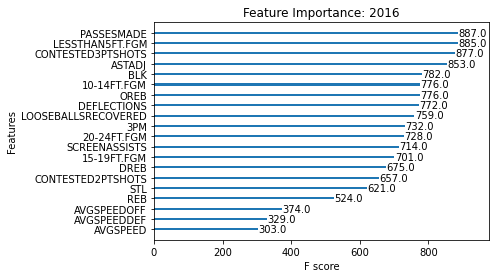

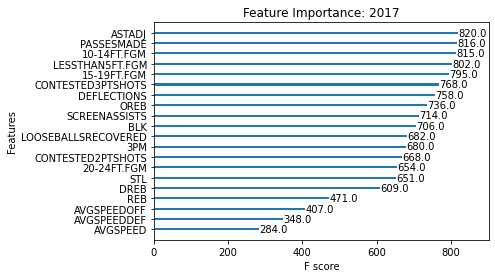

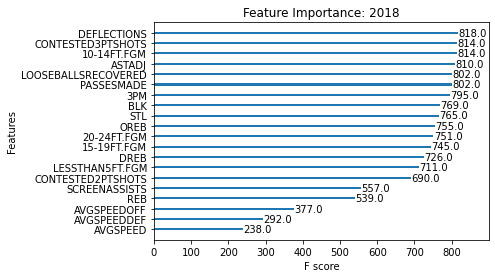

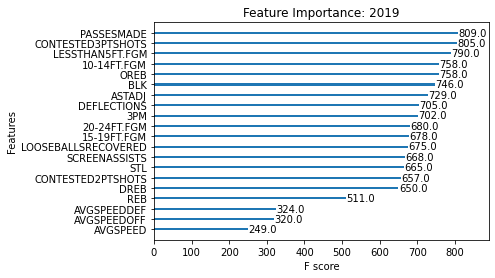

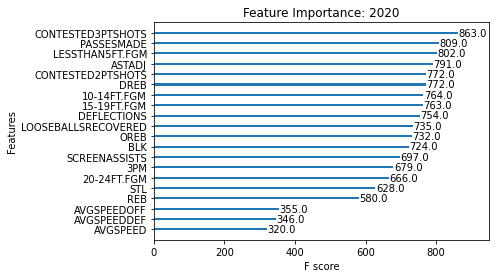

In [39]:
for year in years:
    col = '20{0}/{1}'.format(str(year).zfill(2), str(year+1).zfill(2))
    X[year], y[year] = full_data[year][features+other], full_data[year][col]
    model = XGBClassifier()
    le = LabelEncoder()
    y[year] = le.fit_transform(y[year])
    model.fit(X[year], y[year])
    plot_importance(model, importance_type="weight", grid=False,title='Feature Importance: 20{}'.format(str(year).zfill(2)))
#plot_importance(model, importance_type="weight", max_num_features=5, grid=False,title='Feature Importance')

#pyplot.rcParams['figure.figsize'] = [20, 20]

    pyplot.show()

In [ ]:
X, y = full_data[features+other], full_data[col]

In [ ]:
data_dmatrix = DMatrix(data=X,label=y)

In [ ]:
from xgboost import train
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
xg_reg = train(params=params, dtrain=data_dmatrix, num_boost_round=10)

In [ ]:
plot_tree(xg_reg,num_trees=0)
#pyplot.rcParams['figure.figsize'] = [100, 100]
pyplot.show()

In [ ]:
plot_importance(xg_reg, )

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
model = XGBClassifier()

In [ ]:
model.fit(X, y)

In [ ]:
plot_importance(model, importance_type="weight", grid=False,title='Feature Importance')
#plot_importance(model, importance_type="weight", max_num_features=5, grid=False,title='Feature Importance')

#pyplot.rcParams['figure.figsize'] = [20, 20]

pyplot.show()

In [75]:
full_data[18][(full_data[18]["AGE"] < 26) & (full_data[18]["2018/19"] < 13500000)]

,PLAYER,GP,MIN,DIST.FEET,DIST.MILES,DIST.MILESOFF,DIST.MILESDEF,AVGSPEED,AVGSPEEDOFF,AVGSPEEDDEF,...,PASSESRECEIVED,SECONDARYAST,POTENTIALAST,ASTPTSCREATED.1,ASTADJ,ASTTOPASS%,ASTTOPASS%ADJ,TOTALMIN,Player,2018/19
1,Aaron Holiday,50,12.9,5337.1,1.01,0.52,0.49,4.35,4.58,4.12,...,20.3,0.3,3.1,4.0,1.925775,11.2,13.6,645.0,Aaron Holiday,1914480
2,Abdel Nader,60,11.4,4879.3,0.92,0.47,0.45,4.47,4.70,4.27,...,6.7,0.1,0.7,0.8,0.816761,5.8,6.7,684.0,Abdel Nader,1378242
6,Alex Abrines,31,19.0,7908.3,1.50,0.78,0.72,4.38,4.75,4.04,...,13.0,0.0,1.3,1.6,0.844286,6.4,6.7,589.0,Alex Abrines,3667645
7,Alex Caruso,25,21.3,8538.5,1.62,0.86,0.76,4.23,4.61,3.89,...,31.1,0.4,5.2,7.2,1.981487,10.6,12.8,532.5,Alex Caruso,77250
11,Allonzo Trier,63,22.8,9013.4,1.71,0.95,0.76,4.17,4.51,3.82,...,27.8,0.2,3.7,4.5,1.462280,8.7,10.1,1436.4,Allonzo Trier,3382000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,Tyus Jones,68,22.9,9252.5,1.75,0.96,0.79,4.28,4.64,3.90,...,47.1,0.7,9.0,12.1,2.298647,10.9,12.9,1557.2,Tyus Jones,2444052
344,Wayne Selden,75,19.2,7142.5,1.35,0.73,0.62,3.96,4.17,3.73,...,17.4,0.1,2.5,3.4,1.386294,9.9,10.7,1440.0,Wayne Selden,1544951
348,Willie Cauley-Stein,81,27.3,10642.4,2.02,1.03,0.98,4.16,4.49,3.86,...,24.8,0.3,4.0,5.8,1.545925,7.5,8.7,2211.3,Willie Cauley-Stein,4696874
349,Willy Hernangomez,58,14.0,5757.4,1.09,0.60,0.49,4.38,4.81,3.94,...,15.2,0.1,1.9,2.8,1.468532,4.2,5.1,812.0,Willy Hernangomez,1496500


In [42]:
stat = 'ASTADJ'
full_data[18][['PLAYER', 'TEAM', 'TOTALMIN',stat, '2018/19']].sort_values(stat, ascending=False).reset_index(drop=True).head(15).style.format({"2018/19": "${:20,.0f}", "TOTALMIN": "{:20,.1f}"}).set_properties(**{'text-align': 'right'}).set_properties( subset=['PLAYER', stat, '2018/19'], **{'font-weight': 'bold'} ).hide_index().background_gradient(cmap='Reds',subset='2018/19').bar(subset=[stat], color='#FFA07A')


/var/folders/95/q06718vx3nd9m5683mchd0380000gn/T/ipykernel_50765/1341515054.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  full_data[18][['PLAYER', 'TEAM', 'TOTALMIN',stat, '2018/19']].sort_values(stat, ascending=False).reset_index(drop=True).head(15).style.format({"2018/19": "${:20,.0f}", "TOTALMIN": "{:20,.1f}"}).set_properties(**{'text-align': 'right'}).set_properties( subset=['PLAYER', stat, '2018/19'], **{'font-weight': 'bold'} ).hide_index().background_gradient(cmap='Reds',subset='2018/19').bar(subset=[stat], color='#FFA07A')


PLAYER,TEAM,TOTALMIN,ASTADJ,2018/19
Russell Westbrook,OKC,"2,592.0",2.557227,"$ 35,665,000"
Jeff Teague,MIN,"1,264.2",2.475169,"$ 19,000,000"
Kyle Lowry,TOR,"2,210.0",2.468100,"$ 32,700,000"
Trae Young,ATL,"2,502.9",2.461164,"$ 5,363,280"
Rajon Rondo,LAL,"1,370.8",2.443222,"$ 9,000,000"
Elfrid Payton,NOP,"1,251.6",2.432671,"$ 3,000,000"
Chris Paul,HOU,"1,856.0",2.429218,"$ 35,654,150"
John Wall,WAS,"1,104.0",2.427492,"$ 19,169,800"
Ricky Rubio,UTA,"1,869.3",2.380143,"$ 14,800,000"
D'Angelo Russell,BKN,"2,446.2",2.366088,"$ 7,019,698"


In [ ]:
avg_df = scrape_stats("https://www.nba.com/stats/players/shooting/?Season=2021-22&SeasonType=Regular%20Season&PerMode=Totals")

In [ ]:
avg = avg_df[0].copy()
avg = avg.dropna()
avg = avg.apply(pd.to_numeric, errors='ignore')
avg = avg.append(avg.sum(numeric_only=True), ignore_index=True)

for item in avg.columns:
    if "%" in item:
        print(item)
        avg.iloc[-1, avg.columns.get_loc(item)] = avg.iloc[-1, avg.columns.get_loc(item)-2]/avg.iloc[-1, avg.columns.get_loc(item)-1]
avg.iloc[-1]

In [ ]:
url = "https://www.spotrac.com/nba/free-agents/2019/"
browser.get(url)
#select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))
#select.select_by_visible_text('All')
df = pd.read_html(browser.page_source)[0]

In [ ]:
url = "https://hoopshype.com/salaries/players/2015-2016/"
browser.get(url)
#select = Select(browser.find_element_by_class_name('stats-table-pagination__select'))
#select.select_by_visible_text('All')
df = pd.read_html(browser.page_source)[0]
df = df . reset_index()
df

In [ ]:
shots = pd.DataFrame(columns=['DIST','FGM', 'FGA', 'FG%'])

In [ ]:
df2 = {'DIST': "0-5 FT", 'FGM': 32492, 'FGA': 51954, 'FG%': 0.625399}
shots = shots.append(df2, ignore_index = True)
df2 = {'DIST': "5-9 FT", 'FGM': 7390, 'FGA': 17872, 'FG%': 0.413496}
shots = shots.append(df2, ignore_index = True)
df2 = {'DIST': "10-14 FT", 'FGM': 5600, 'FGA': 13031, 'FG%': 0.429744}
shots = shots.append(df2, ignore_index = True)
df2 = {'DIST': "15-19 FT", 'FGM': 4513, 'FGA': 10902, 'FG%': 0.413961}
shots = shots.append(df2, ignore_index = True)
df2 = {'DIST': "20-24 FT", 'FGM': 9552, 'FGA': 25698, 'FG%': 0.371702}
shots = shots.append(df2, ignore_index = True)
df2 = {'DIST': "25-29 FT", 'FGM': 13722, 'FGA': 40044, 'FG%': 0.342673}
shots = shots.append(df2, ignore_index = True)

In [ ]:
shots.head(15).style.format().set_properties(**{'text-align': 'right'}).set_properties( subset=['DIST', 'FGM', 'FGA', 'FG%'], **{'font-weight': 'bold'} ).hide_index().background_gradient(cmap='Reds',subset=['FG%', 'FGM']).bar(subset=["FGA"], color='#FFA07A')